<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

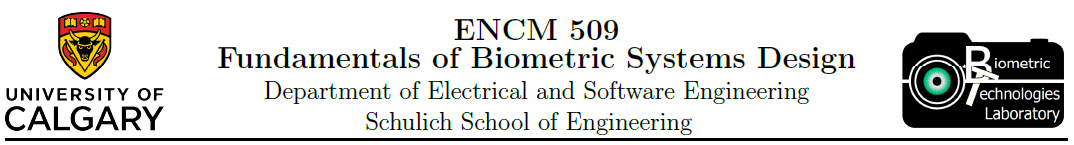

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib as mpl

from scipy import ndimage as ndi

from sklearn.feature_extraction.image import extract_patches_2d

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils_encm.blockproc import blockproc
from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.align2 import align2
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

#### Some auxiliary functitons

In [5]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

In [4]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Reading image

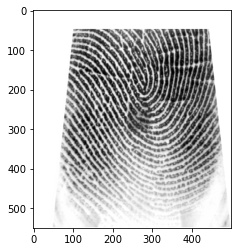

In [6]:
# the image loaded is already [0,1]
img = imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True)
plt.imshow(img, cmap='gray');

### Plotting the Gabor filters

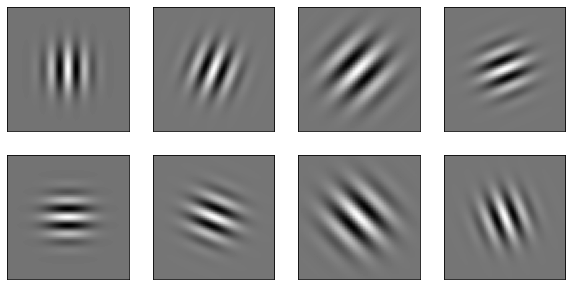

In [7]:
# +0.1 because python discart the last value
angle = np.arange(0, np.pi-np.pi/8+0.1, np.pi/8)
# filter size: x, y
xsize = 32; ysize = 32
# standard deviation of the gaussian envelope
dx = 8; dy = 8
# frequency
fq = 0.11

plt.figure(figsize=(10,5))

# filtering and feature extraction
for i,a in enumerate(angle):
    # build the filter
    gabor = np.real(gabor_kernel(fq, theta=a, sigma_x=dx, sigma_y=dy, n_stds=4))
    
    # show Gabor filters
    plt.subplot(2, 4, i+1)
    plt.imshow(gabor, cmap='gray', aspect='auto')
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

#### 3D representation of the Gabor filter

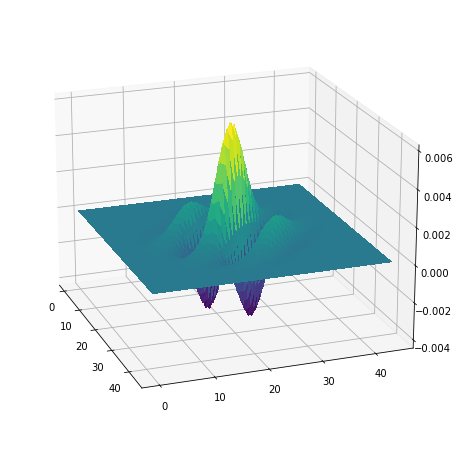

In [8]:
fi = gabor_template(img, angle=np.pi/4)

# Filter as a 3D function
fi_r, fi_c = fi.shape

X = np.arange(0, fi_c)
Y = np.arange(0, fi_r)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, fi, cmap=cm.viridis,
                       linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)

## Gabor Filter for Ridge detection

### Filtering with Gabor filter in $\pi/4$ degrees

In [9]:
img_f = gabor_filtering(img, fi)

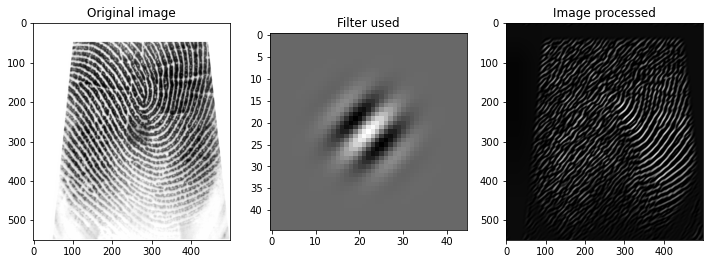

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f, cmap='gray'); plt.title('Image processed');

### Filtering with Gabor filter in $-\pi/4$ degrees

In [11]:
fi = gabor_template(img, angle=-np.pi/4)
img_f = gabor_filtering(img, fi)

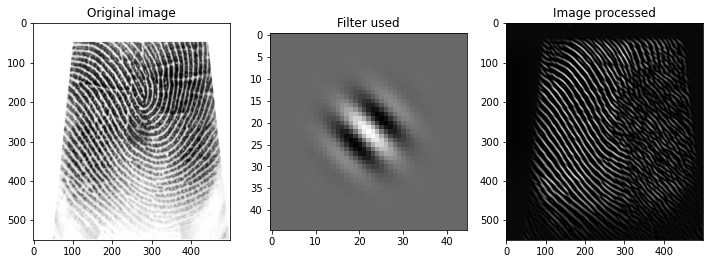

In [12]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(fi, cmap='gray'); plt.title('Filter used')
plt.subplot(1,3,3)
plt.imshow(img_f, cmap='gray'); plt.title('Image processed');

## Matching:  Gabor feature-based matching

### Images from the `same` person

In [13]:
# both images HAVE to have the same size!!

im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/14.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))

Score using Gabor features: 15.2020


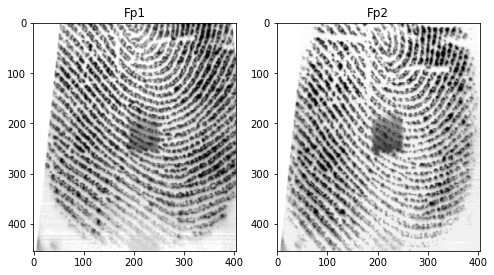

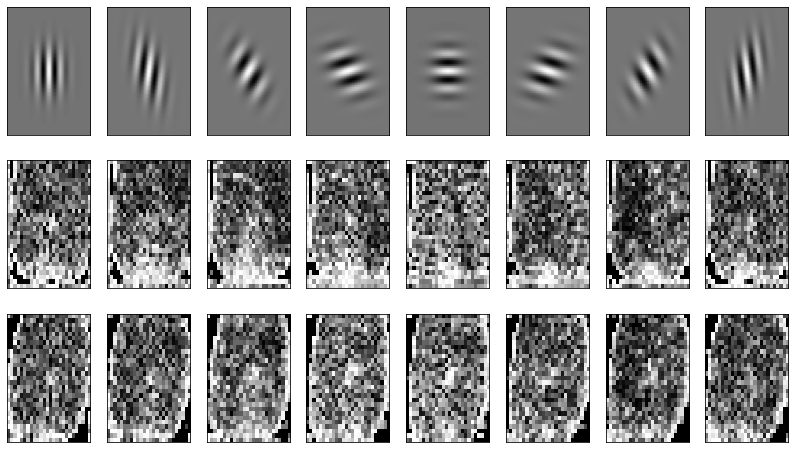

In [14]:
# if you don't want to see the plot, set the parameter: plot_res=False
score1 = MatchGaborFeat(im1, im2, plot_res=True)
print('Score using Gabor features: %.4f' % (score1))

### Images from two `different` people

In [15]:
# Subject 1
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/14.bmp', as_gray=True))

# Subject 2
im4 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/1.bmp', as_gray=True))

Score using Gabor features: 17.2868


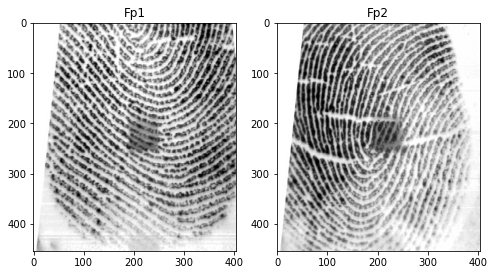

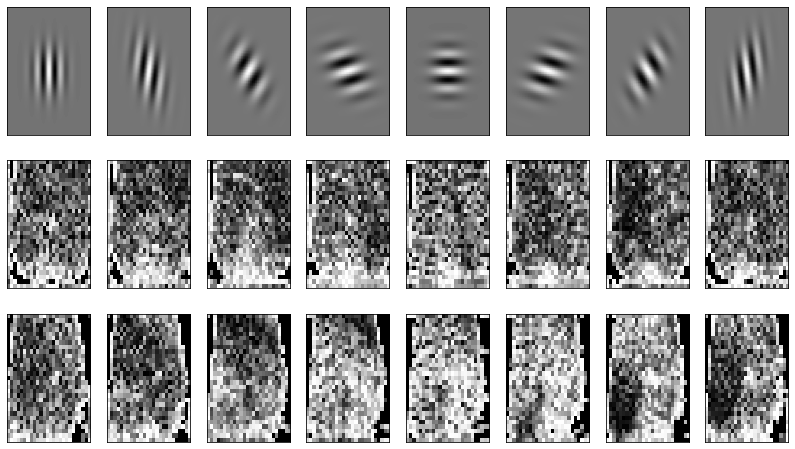

In [16]:
# if you don't want to see the plot, set the parameter: plot_res=False
score2 = MatchGaborFeat(im1, im4, plot_res=True)
print('Score using Gabor features: %.4f' % (score2))

## Matching: Minutiae based

### Images from the `same` person

In [17]:
# both images HAVE to have the same size!!
im1 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/2.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/3.bmp', as_gray=True))

Fp1 = fingerprint_processing(im1, block_size=12, threshold=0.1)
Fp2 = fingerprint_processing(im2, block_size=12, threshold=0.1)

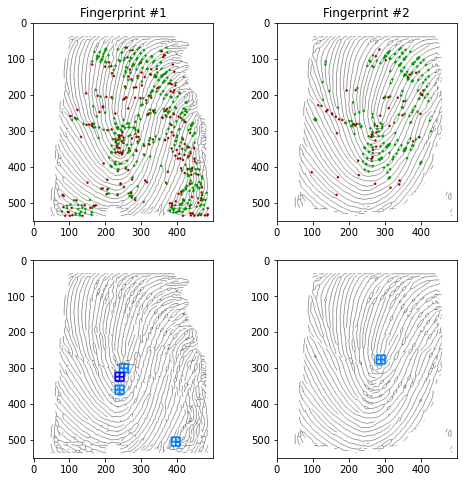

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(Fp1['minutiae_img'])
plt.title('Fingerprint #1')
plt.subplot(2,2,2)
plt.imshow(Fp2['minutiae_img'])
plt.title('Fingerprint #2')
plt.subplot(2,2,3)
plt.imshow(Fp1['singularities_img'])
plt.subplot(2,2,4)
plt.imshow(Fp2['singularities_img']);

In [19]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 128
distance total computed : 580
number of minutiae in input image: 2518
number of minutiae in database image: 839
score for minutiae: 0.0763



### Images from two `different` people

In [20]:
im3 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im4 = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/4.bmp', as_gray=True))

Fp3 = fingerprint_processing(im3, block_size=12, threshold=0.1)
Fp4 = fingerprint_processing(im4, block_size=12, threshold=0.1)

In [21]:
# Minutiae matching
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp3, Fp4)
Fp4['imSkeletonAlign'] = imSkeletonAlign
Fp4['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp3, Fp4, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 164
distance total computed : 754
number of minutiae in input image: 3468
number of minutiae in database image: 756
score for minutiae: 0.0777



## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART II (Lab 5): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file to perform the Gabor filtering for ridge detection on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

In [3]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

Text(0.5, 1.0, 'Image processed')

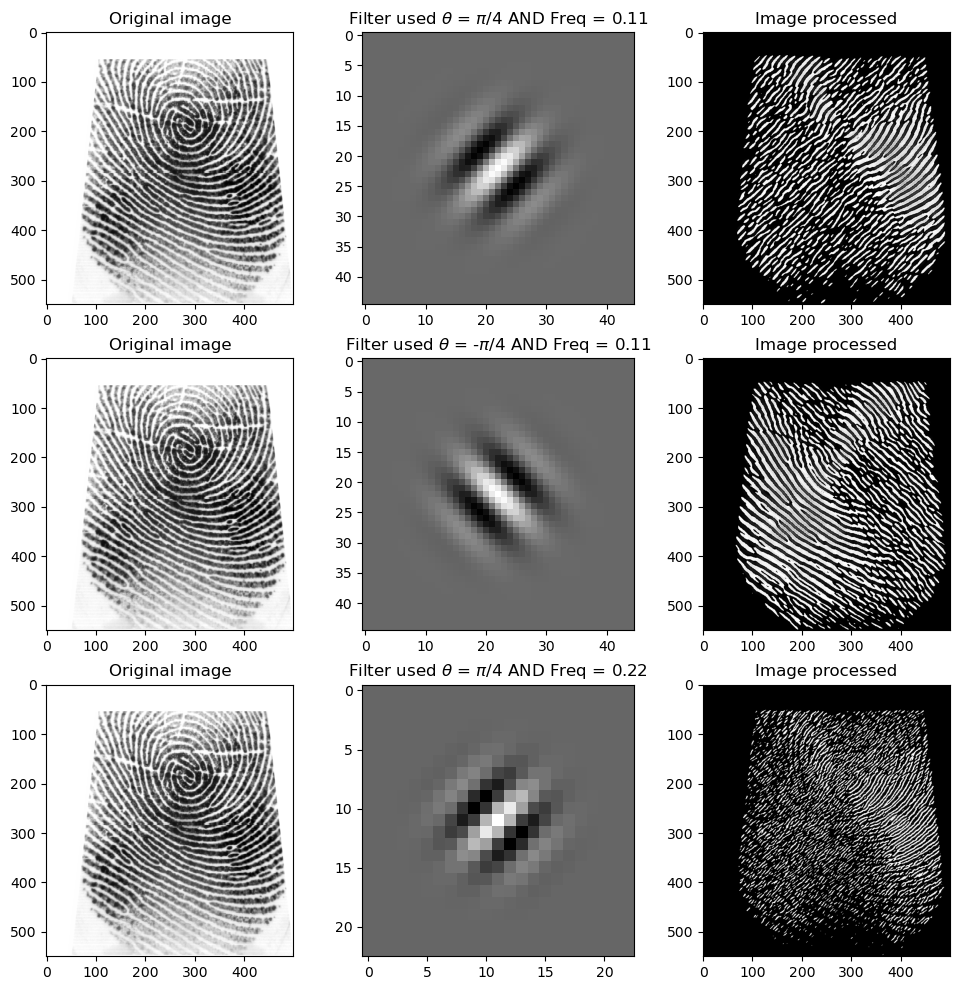

In [4]:
img = img_as_ubyte(imread('fingerprints/ali_right/5.bmp', as_gray=True))

fi_1 = gabor_template(img, angle=np.pi/4, freq=0.11)
img_f1 = gabor_filtering(img, fi_1)

fi_2 = gabor_template(img, angle=-np.pi/4, freq=0.11)
img_f2 = gabor_filtering(img, fi_2)

fi_3 = gabor_template(img, angle=np.pi/4, freq=0.22)
img_f3 = gabor_filtering(img, fi_3)

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(fi_1, cmap='gray'); plt.title(r'Filter used $\theta$ = $\pi$/4 AND Freq = 0.11')
plt.subplot(3,3,3)
plt.imshow(img_f1, cmap='gray'); plt.title('Image processed')
plt.subplot(3,3,4)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,5)
plt.imshow(fi_2, cmap='gray'); plt.title(r'Filter used $\theta$ = -$\pi$/4 AND Freq = 0.11')
plt.subplot(3,3,6)
plt.imshow(img_f2, cmap='gray'); plt.title('Image processed')
plt.subplot(3,3,7)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,8)
plt.imshow(fi_3, cmap='gray'); plt.title(r'Filter used $\theta$ = $\pi$/4 AND Freq = 0.22')
plt.subplot(3,3,9)
plt.imshow(img_f3, cmap='gray'); plt.title('Image processed')

## Exercise 1 Analysis

**Changing the angle emphasises/extracts the lines/skeletons that are facing that angle from the original fingerprint. In the first example, the angle is 45 degrees, meaning that the filter emphasises the lines that are oriented in the +45 degree direction, which is on the right side of the fingerprint image. Likewise, changing the angle to -45 degrees emphasises on the lines going in the -45 degree direction as seen in the 2nd set of figures, which happens to be on the left side of the fingerprint image. Increasing the frequency (3rd set of images) emphasises the area of the fingerprint image that has higher frequencie (i.e., the skeleton lines are closer together).**

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    - Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    - Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    - Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

In [3]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [4]:
images = []
for i in range(1, 10):
    image_path_string = 'fingerprints/ali_right/' + str(i) + '.bmp'
    images.append(img_as_ubyte(imread(image_path_string, as_gray=True)))

test_image = img_as_ubyte(imread('fingerprints/ali_right/10.bmp', as_gray=True))

Fps = []
for i in range(0, 9):
    Fps.append(fingerprint_processing(images[i], block_size=12, threshold=0.1))

test_fp = fingerprint_processing(test_image, block_size=12, threshold=0.1)

scores = []
for i in range(0, 9):
    imSkeletonAlign, minutiaArrayAlign = align2(Fps[i], test_fp)
    test_fp['imSkeletonAlign'] = imSkeletonAlign
    test_fp['minutiaArrayAlign'] = minutiaArrayAlign
    match_threshold = 6
    score = match(Fps[i], test_fp, threshold2=match_threshold)
    scores.append(score)
    print()

number of matched minutiae: 71
distance total computed : 316
number of minutiae in input image: 2942
number of minutiae in database image: 473

number of matched minutiae: 117
distance total computed : 512
number of minutiae in input image: 2969
number of minutiae in database image: 444

number of matched minutiae: 130
distance total computed : 558
number of minutiae in input image: 2969
number of minutiae in database image: 558

number of matched minutiae: 94
distance total computed : 404
number of minutiae in input image: 2969
number of minutiae in database image: 560

number of matched minutiae: 75
distance total computed : 357
number of minutiae in input image: 2942
number of minutiae in database image: 790

number of matched minutiae: 60
distance total computed : 302
number of minutiae in input image: 2542
number of minutiae in database image: 598

number of matched minutiae: 77
distance total computed : 335
number of minutiae in input image: 2969
number of minutiae in database im

In [10]:
TP = 0
FN = 0

threshold = np.mean(scores) - np.std(scores)
print("Match Threshold is %.4f\n" % (threshold))

for i in range(0, 9):
    print('Score for Image %d vs. Probe Image: %.4f' % (i, scores[i]))
    if( scores[i] >= threshold ):
        TP += 1
    else:
        FN += 1

print()
print("Number of True Positives: %d" % (TP))
print("Number of False Negatives: %d" % (FN))

Match Threshold is 0.0397

Score for Image 0 vs. Probe Image: 0.0416
Score for Image 1 vs. Probe Image: 0.0686
Score for Image 2 vs. Probe Image: 0.0737
Score for Image 3 vs. Probe Image: 0.0533
Score for Image 4 vs. Probe Image: 0.0402
Score for Image 5 vs. Probe Image: 0.0382
Score for Image 6 vs. Probe Image: 0.0463
Score for Image 7 vs. Probe Image: 0.0800
Score for Image 8 vs. Probe Image: 0.0482

Number of True Positives: 8
Number of False Negatives: 1


## Exercise 2 Analysis

| Image | Score | True Positive | False Negative |
| :-: | :-: | :-: | :-: |
| 0 | 0.0416 | yes | no |
| 0 | 0.0686 | yes | no |
| 0 | 0.0737 | yes | no |
| 0 | 0.0533 | yes | no |
| 0 | 0.0402 | yes | no |
| 0 | 0.0382 | no | yes |
| 0 | 0.0463 | yes | no |
| 0 | 0.0800 | yes | no |
| 0 | 0.0482 | yes | no |

**From the data and the Table above we can see that using a threshold of 0.0397 yeilds a True Positive rate of 8/9 = 89% and False Negative rate of 1/9 = 11% which is very good. It is clear to see that as we increase the match threshold the True positive rate will decrease and the False Negative rate will increase. (E.g., if we set the threshold to 0.05, out TP rate will become 4/9 = 44%, and FN rate will be 5/9 = 56%)**

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.